<div align="center">

# <font face="Gramond" color="mediumvioletred"> Project: Restaurant Feedback Analysis </font>

<hr style="border: 0.5px solid white;">

</div>


## <font face="Gramond" color="peachpuff"> Part 1: Web Scraping </font>

In [ ]:
! pip install beautifulsoup4
! pip install requests
! pip install selenium
! pip install webdriver-manager

In [9]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import json
import csv

driver = webdriver.Chrome()

url = "https://www.opentable.com/r/pietros-italian-walnut-philadelphia?corrid=b571a2e0-9dc6-4e22-a4f5-a592a82ed85b&avt=eyJ2IjoyLCJtIjoxLCJwIjowLCJzIjowLCJuIjowfQ&p=2&sd=2024-11-30T19%3A00%3A00"

driver.get(url)
time.sleep(3)

data = []

In [ ]:
restaurant_name = driver.find_element(By.CLASS_NAME, 'E-vwXONV9nc-').text
print(restaurant_name)

def extract():
    while True:
        names = driver.find_elements(By.CLASS_NAME, '_0Uufw15R3a4-')
        customer_names = [name.find_element(By.CLASS_NAME, '_1p30XHjz2rI-').text for name in names if name.text]

        items = driver.find_elements(By.CLASS_NAME, 'MpiILQAMSSg-')
        for i in range(len(items)):
            try:
                content = items[i].find_element(By.CLASS_NAME, '_6rFG6U7PA6M-')
                date = items[i].find_element(By.CLASS_NAME, 'iLkEeQbexGs-')
                rating_element = items[i].find_element(By.CLASS_NAME, 'yEKDnyk-7-g-')  
                rating = rating_element.get_attribute("aria-label")

                customer_name = customer_names[i] if i < len(customer_names) else None

                data.append({
                    "restaurant_name": restaurant_name,
                    "customer_name": customer_name,
                    "review_content": content.text,
                    "rating": rating,
                    "review_date": date.text
                })
            except Exception as e:
                print(f"Error processing review item: {e}")
        
        print("DONE")

        try:
            footer = driver.find_element(By.CLASS_NAME, '_1BEc9Aeng-Q-')
            buttons = footer.find_elements(By.CLASS_NAME, 'TkpxbcBbu80-')

            if len(buttons) > 1: # for if there are more than one button
                next_button = buttons[1] 
            else: 
                next_button = buttons[0] 

            if "disabled" in next_button.get_attribute("class"): 
                print("No more pages to load.")
                break

            next_button.click() 
            print("Navigating to the next page...")
            time.sleep(3)

        except Exception as e:
            print("Error while trying to find the 'Next' button:", e)
            print("Breaking the loop, no more pages available.")
            break 

extract()

In [14]:
with open('reviews.json', 'w') as json_file:
    json.dump(data, json_file, indent = 4)

<hr style="border: 1px solid pink;">

## <font face="Gramond" color="peachpuff"> Part 2: Prompt Engineering </font>

In [ ]:
import os
# Set the environment variable within the notebook
os.environ["ANTHROPIC_API_KEY"] = " "

In [ ]:
import anthropic
import json 

client = anthropic.Anthropic()

with open('reviews.json', 'r') as file:
    data = json.load(file)

def process(review_text):
    print(f"Processing review: {review_text}")
    system_prompt = "You are a highly intelligent and structured assistant. Extract relevant data from reviews."
    user_message = f""" 
    Analyze the following restaurant review and extract the following information:
    1. Comments about food quality.
    2. Comments about staff/service.
    Ensure that:
    - No irrelevant data is included.
    - Exclude any hallucinated or made-up content.
    - Exclude any personal information about the reviewer.
    Respond in this exact JSON format:
    {{
        "food_quality": "Extracted comments about food quality.",
        "staff_service": "Extracted comments about staff or service."
    }}
    Review: "{review_text}"
    """

    try:
        response = client.completions.create(
            model="claude-3-5-sonnet-20241022",
            max_tokens=1000, 
            temperature=0,
            prompt=system_prompt, 
            messages=[{"role": "user", "content": user_message}]
        )

        text_content = response['completion'].strip()
        print(f"Raw response: {text_content}")
     
        return json.loads(text_content)

    except Exception as e:
        print(f"Error processing review: {e}")
        return {"food_quality": "", "staff_service": ""}

results = []
for review in data:
    review_content = review["review_content"] 
    extracted_data = process(review_content)
    results.append({
        "review": review,
        "extracted_data": extracted_data
    })

with open("processed_reviews.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

print("Reviews processed and saved to 'processed_reviews.json'")


In [ ]:
from groq import Groq
import os
os.environ['GROQ_API_KEY'] = ' '


In [31]:
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

In [ ]:
def ask(message, sys_message, model="llama3-8b-8192"):
    """
    Function to send a message to the Groq model and receive a response.
    """
    messages = [
        {"role": "system", "content": sys_message},
        {"role": "user", "content": message}
    ]

    response = client.chat.completions.create(model=model, messages=messages)
    return response.choices[0].message.content


def process_review(review_content):
    """
    Function to process a single review using the Groq model.
    """
    print(f"Processing review: {review_content}")

    system_prompt = "You are a highly structured assistant. Extract relevant comments about food and service from reviews."
    user_message = f"""
    Analyze the restaurant review below and extract the following information:
    - Specific comments about food quality (e.g., taste, freshness, presentation).
    - Specific comments about staff/service (e.g., attentiveness, friendliness).
    Exclude irrelevant data and personal information.
    Review: "{review_content}"
    Respond in strict JSON format with the keys: 'food_quality' and 'staff_service'.
    """

    try:
        response_text = ask(user_message, system_prompt)

        parsed_response = json.loads(response_text)

        return {
            "food_quality": parsed_response.get("food_quality", "") or "No comments on food quality.",
            "staff_service": parsed_response.get("staff_service", "") or "No comments on staff service."
        }
    except Exception as e:
        print(f"Error processing review: {e}")
        return {"food_quality": "", "staff_service": ""}


reviews_file = "reviews.json"
output = []

with open(reviews_file, "r", encoding="utf-8") as jsonfile:
    reviews_data = json.load(jsonfile)

for review in reviews_data:
    review_content = review.get("review_content", "")
    if review_content:
        processed_review = process_review(review_content)
        output.append({
            "restaurant_name": review.get("restaurant_name", ""),
            "customer_name": review.get("customer_name", ""),
            "review_date": review.get("review_date", ""),
            "rating": review.get("rating", ""),
            "food_quality": processed_review.get("food_quality", ""),
            "staff_service": processed_review.get("staff_service", "")
        })

with open("processed_reviews.json", "w", encoding="utf-8") as jsonfile:
    json.dump(output, jsonfile, indent=4, ensure_ascii=False)

print("Reviews processed and saved to 'processed_reviews.json'.")

Processing review: Food and service were excellent.  We have been here many times …. Never disappoints
Error processing review: Expecting value: line 1 column 1 (char 0)
Processing review: Rudolf providers attentive service. Great pizza! No complaints
Error processing review: Expecting value: line 1 column 1 (char 0)
Processing review: Great place for a couple adults and kids. Nice atmosphere and ambiance but not stuffy.
Error processing review: Expecting value: line 1 column 1 (char 0)
Processing review: Overall a great experience on Walnut St.  This location is just noisy.

DC
Processing review: Excellent as always! Food is delicious. My reserved table was ready on schedule. Very nice experience.
Processing review: Was very good food and staff was very kind even though we were late!
Error processing review: Expecting value: line 1 column 1 (char 0)
Processing review: Great location. Delicious food and fantastic service.
Processing review: Delicious!  Perfect dinner after seeing Hamil

In [34]:
import json
import os
processed_reviews = []

def process_reviews(file_path, max_reviews=500):
    # Load the JSON data
    with open(file_path, 'r') as f:
        reviews_data = json.load(f)
    

    for i, review in enumerate(reviews_data[:max_reviews]):
        message = review.get("review_content", "")
        sys_message = """You are a helpful assistant. Your task is to analyze and categorize reviews into two categories: 
1. Comments about food quality.
2. Comments about staff/service.

Please ensure the following:
- Extract and include only the information relevant to each category. No irrelevant or unrelated information should be added.
- Comments about food quality should contain only food-related data, with no staff-related information.
- Comments about staff/service should contain only staff/service-related data, with no food-related information.
- Exclude any personal information (e.g., names, locations, or other identifiers) of the reviewers.
- Categorize the sentiment for each section as 'Positive' or 'Negative'. 

Here is a review for you to process:

Review: "{review_text}"

Please provide the response in the following format:
Food Quality: [Provide categorized comments about food quality] - Sentiment: [Positive/Negative]
Service: [Provide categorized comments about staff/service] - Sentiment: [Positive/Negative]"""
        
        try:
            # Send to model
            response = client.chat.completions.create(
                model="llama3-8b-8192",
                messages=[
                    {"role": "system", "content": sys_message},
                    {"role": "user", "content": message}
                ]
            )
            
            # Process the response
            model_output = response.choices[0].message.content
            print(f"Processing review {i + 1}/{max_reviews}: {model_output}")  # Debugging step

            processed_reviews.append({
                "food_quality": extract_food_info(model_output),
                "staff_service": extract_service_info(model_output)
            })
        except Exception as e:
            print(f"Error processing review {i + 1}: {e}")
            continue

    # Save the processed data
    output_file = "processed_reviews2.json"
    with open(output_file, "w") as f:
        json.dump(processed_reviews, f, indent=4)

    print(f"Processing complete. Saved to '{output_file}'.")

def extract_food_info(text):
    try:
        if "Food Quality:" in text:
            content = text.split("Food Quality:")[1].split("Service:")[0].strip()
            sentiment = content.split("Sentiment:")[1].strip() if "Sentiment:" in content else "No sentiment available"
            food_quality_comment = content.split("Sentiment:")[0].strip()
            return {"comment": food_quality_comment, "sentiment": sentiment}
        else:
            return {"comment": "No information available about food quality.", "sentiment": "No sentiment available"}
    except IndexError:
        return {"comment": "No information available about food quality.", "sentiment": "No sentiment available"}

def extract_service_info(text):
    try:
        if "Service:" in text:
            content = text.split("Service:")[1].strip()
            sentiment = content.split("Sentiment:")[1].strip() if "Sentiment:" in content else "No sentiment available"
            service_comment = content.split("Sentiment:")[0].strip()
            return {"comment": service_comment, "sentiment": sentiment}
        else:
            return {"comment": "No information available about customer service.", "sentiment": "No sentiment available"}
    except IndexError:
        return {"comment": "No information available about customer service.", "sentiment": "No sentiment available"}


process_reviews("reviews.json", max_reviews=1000)

Error processing review 1: name 'client' is not defined
Error processing review 2: name 'client' is not defined
Error processing review 3: name 'client' is not defined
Error processing review 4: name 'client' is not defined
Error processing review 5: name 'client' is not defined
Error processing review 6: name 'client' is not defined
Error processing review 7: name 'client' is not defined
Error processing review 8: name 'client' is not defined
Error processing review 9: name 'client' is not defined
Error processing review 10: name 'client' is not defined
Error processing review 11: name 'client' is not defined
Error processing review 12: name 'client' is not defined
Error processing review 13: name 'client' is not defined
Error processing review 14: name 'client' is not defined
Error processing review 15: name 'client' is not defined
Error processing review 16: name 'client' is not defined
Error processing review 17: name 'client' is not defined
Error processing review 18: name 'client

<hr style="border: 1px solid pink;">

## <font face="Gramond" color="peachpuff"> Part 3: GUI Development </font>

In [ ]:
!pip install streamlit

In [ ]:
%%writefile app.py
import streamlit as st
import json
import pandas as pd
import base64
from pathlib import Path

# Load JSON data
def load_json_data(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except Exception as e:
        st.error(f"Error loading {file_path}: {e}")
        return []

def display_stars(rating_text):
    try:
        rating = int(rating_text.split()[0]) 
        return "⭐" * rating
    except:
        return "No Rating"

def highlight_text(text, sentiment, category):
    if category == "food":
        return f"<span style='color: indianred; font-weight: bold'>{text}</span><br><span style='color: darkred;'>Sentiment: {sentiment}</span>"
    elif category == "service":
        return f"<span style='color: teal; font-weight: bold'>{text}</span><br><span style='color: darkblue;'>Sentiment: {sentiment}</span>"
    return text

def add_background(image_path):
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode()
        st.markdown(
            f"""
            <style>
            .stApp {{
                background-image: url("data:image/jpeg;base64,{encoded_string}");
                background-size: cover;
                background-position: center;
                background-repeat: no-repeat;
            }}
            </style>
            """,
            unsafe_allow_html=True
        )
    except Exception as e:
        st.warning(f"Background image could not be loaded: {e}")

background_image = "ele.jpg"

processed_reviews = load_json_data("final_reviews.json")
original_reviews = load_json_data("reviews.json")

add_background(background_image)

st.title("Pietro's Italian - Walnut Dashboard")

st.sidebar.header("Filter Reviews")
filter_rating = st.sidebar.selectbox("Filter by Rating:", ["All", "5 stars", "4 stars", "3 stars", "2 stars", "1 star"])
search_customer = st.sidebar.text_input("Search by Customer Name:")

ratings_count = {}
for review in original_reviews:
    rating_text = review.get("rating", "No Rating")
    try:
        rating = int(rating_text.split()[0])
        ratings_count[rating] = ratings_count.get(rating, 0) + 1
    except:
        continue

st.sidebar.subheader("Ratings Distribution")
st.sidebar.bar_chart(pd.DataFrame.from_dict(ratings_count, orient='index', columns=["Count"]))

for original, processed in zip(original_reviews, processed_reviews):
    customer_name = original.get("customer_name", "Unknown Customer")
    review_content = original.get("review_content", "No review content available")
    rating = original.get("rating", "No Rating")
    stars = display_stars(rating)
    review_date = original.get("review_date", "No Date")
    food_quality = processed.get("food_quality", {"comment": "No Food Review", "sentiment": "Neutral"})
    staff_service = processed.get("staff_service", {"comment": "No Service Review", "sentiment": "Neutral"})

    if filter_rating != "All" and filter_rating != rating:
        continue
    if search_customer and search_customer.lower() not in customer_name.lower():
        continue

    with st.expander(f"Review by {customer_name}"):
        st.write(f"*Review Date:* {review_date}")
        st.write(f"*Rating:* {stars}")
        st.markdown(f"*Review Content:* {review_content}")
        st.markdown(f"<br><b>Food Quality:</b> {highlight_text(food_quality['comment'], food_quality['sentiment'], 'food')}", unsafe_allow_html=True)
        st.markdown(f"<br><b>Staff Service:</b> {highlight_text(staff_service['comment'], staff_service['sentiment'], 'service')}", unsafe_allow_html=True)

st.markdown("---")
st.markdown("### - by Minahil Rizwan")


Overwriting app.py


In [2]:
%%writefile dashboard1.py
import streamlit as st
import json
import pandas as pd
import base64
from pathlib import Path

# Load JSON data
def load_json_data(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except Exception as e:
        st.error(f"Error loading {file_path}: {e}")
        return []

def display_stars(rating_text):
    try:
        rating = int(rating_text.split()[0]) 
        return "⭐" * rating
    except:
        return "No Rating"

def highlight_text(text, sentiment, category):
    sentiment_color = "peachpuff" if sentiment.lower() in ["positive", "negative"] else "gray"
    if category == "food":
        return f"<span style='color: indianred; font-weight: bold'>{text}</span><br><span style='color: white; font-weight: bold;'>Sentiment: <span style='color: {sentiment_color};'>{sentiment}</span></span>"
    elif category == "service":
        return f"<span style='color: mediumaquamarine; font-weight: bold'>{text}</span><br><span style='color: white; font-weight: bold;'>Sentiment: <span style='color: {sentiment_color};'>{sentiment}</span></span>"
    return text

def add_background(image_path):
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode()
        st.markdown(
            f"""
            <style>
            .stApp {{
                background-image: url("data:image/jpeg;base64,{encoded_string}");
                background-size: cover;
                background-position: center;
                background-repeat: no-repeat;
            }}
            </style>
            """,
            unsafe_allow_html=True
        )
    except Exception as e:
        st.warning(f"Background image could not be loaded: {e}")

background_image = "ele.jpg"

processed_reviews = load_json_data("final_reviews.json")
original_reviews = load_json_data("reviews.json")

add_background(background_image)

st.title("Pietro's Italian - Walnut Dashboard")

st.sidebar.header("Filter Reviews")
filter_rating = st.sidebar.selectbox("Filter by Rating:", ["All", "5 stars", "4 stars", "3 stars", "2 stars", "1 star"])
search_customer = st.sidebar.text_input("Search by Customer Name:")

ratings_count = {}
for review in original_reviews:
    rating_text = review.get("rating", "No Rating")
    try:
        rating = int(rating_text.split()[0])
        ratings_count[rating] = ratings_count.get(rating, 0) + 1
    except:
        continue

st.sidebar.subheader("Ratings Distribution")
st.sidebar.bar_chart(pd.DataFrame.from_dict(ratings_count, orient='index', columns=["Count"]))

for original, processed in zip(original_reviews, processed_reviews):
    customer_name = original.get("customer_name", "Unknown Customer")
    review_content = original.get("review_content", "No review content available")
    rating = original.get("rating", "No Rating")
    stars = display_stars(rating)
    review_date = original.get("review_date", "No Date")
    food_quality = processed.get("food_quality", {"comment": "No Food Review", "sentiment": "Neutral"})
    staff_service = processed.get("staff_service", {"comment": "No Service Review", "sentiment": "Neutral"})

    if filter_rating != "All" and filter_rating != rating:
        continue
    if search_customer and search_customer.lower() not in customer_name.lower():
        continue

    with st.expander(f"Review by {customer_name}"):
        st.write(f"*Review Date:* {review_date}")
        st.write(f"*Rating:* {stars}")
        st.markdown(f"*Review Content:* {review_content}")
        st.markdown(f"<br><b>Food Quality:</b> {highlight_text(food_quality['comment'], food_quality['sentiment'], 'food')}", unsafe_allow_html=True)
        st.markdown(f"<br><b>Staff Service:</b> {highlight_text(staff_service['comment'], staff_service['sentiment'], 'service')}", unsafe_allow_html=True)

st.markdown("---")
st.markdown("### - by Minahil Rizwan")


Overwriting dashboard1.py


<hr style="border: 1px solid pink;">

## <font face="Gramond" color="peachpuff"> Part 4: Competitor Analysis </font>

In [24]:
import requests
from bs4 import BeautifulSoup

url2 = input("Enter the URL of the restaurant: ")

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'}
response = requests.get(url2, headers=headers)

if response.status_code == 200:
    print("Success")
else:
    print("Failure")   
     

Success


In [25]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import json

driver2 = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver2.get(url2)
time.sleep(3)

data2 = []

In [ ]:
restaurant_name = driver2.find_element(By.CLASS_NAME, 'E-vwXONV9nc-').text
print(restaurant_name)

def extract():
    while True:
        names = driver2.find_elements(By.CLASS_NAME, '_0Uufw15R3a4-')
        customer_names = [name.find_element(By.CLASS_NAME, '_1p30XHjz2rI-').text for name in names if name.text]

        items = driver2.find_elements(By.CLASS_NAME, 'MpiILQAMSSg-')
        for i in range(len(items)):
            try:
                content = items[i].find_element(By.CLASS_NAME, '_6rFG6U7PA6M-')
                date = items[i].find_element(By.CLASS_NAME, 'iLkEeQbexGs-')
                rating_element = items[i].find_element(By.CLASS_NAME, 'yEKDnyk-7-g-')  
                rating = rating_element.get_attribute("aria-label")

                customer_name = customer_names[i] if i < len(customer_names) else None

                data2.append({
                    "restaurant_name": restaurant_name,
                    "customer_name": customer_name,
                    "review_content": content.text,
                    "rating": rating,
                    "review_date": date.text
                })
            except Exception as e:
                print(f"Error processing review item: {e}")
        
        print("DONE")

        try:
            footer = WebDriverWait(driver2, 10).until(
                EC.presence_of_element_located((By.CLASS_NAME, '_1BEc9Aeng-Q-'))
            )
            buttons = footer.find_elements(By.CLASS_NAME, 'TkpxbcBbu80-')

            if len(buttons) > 1:
                next_button = buttons[1] 
            else:
                next_button = buttons[0] 

            if "disabled" in next_button.get_attribute("class"):
                print("No more pages to load.")
                break

            next_button.click()
            print("Navigating to the next page...")
            time.sleep(3)

        except Exception as e:
            if "no such window" in str(e):
                print("Browser window closed unexpectedly. Terminating gracefully.")
            else:
                print("Error while trying to find the 'Next' button:", e)
                print("Current URL:", driver2.current_url)
            break

extract()


In [29]:
with open('second.json', 'w') as json_file:
    json.dump(data2, json_file, indent = 4)

In [6]:
%%writefile dashboard1.py
import streamlit as st
import json
import pandas as pd
import base64
import time
import logging
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json

def load_json_data(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except Exception as e:
        st.error(f"Error loading {file_path}: {e}")
        return []

def display_stars(rating_text):
    try:
        rating = int(rating_text.split()[0]) 
        return "⭐" * rating
    except:
        return "No Rating"

def highlight_text(text, sentiment, category):
    sentiment_color = "peachpuff" if sentiment.lower() in ["positive", "negative"] else "gray"
    if category == "food":
        return f"<span style='color: indianred; font-weight: bold'>{text}</span><br><span style='color: white; font-weight: bold;'>Sentiment: <span style='color: {sentiment_color};'>{sentiment}</span></span>"
    elif category == "service":
        return f"<span style='color: teal; font-weight: bold'>{text}</span><br><span style='color: white; font-weight: bold;'>Sentiment: <span style='color: {sentiment_color};'>{sentiment}</span></span>"
    return text

def add_background(image_path):
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode()
        st.markdown(
            f"""
            <style>
            .stApp {{
                background-image: url("data:image/jpeg;base64,{encoded_string}");
                background-size: cover;
                background-position: center;
                background-repeat: no-repeat;
            }}
            </style>
            """,
            unsafe_allow_html=True
        )
    except Exception as e:
        st.warning(f"Background image could not be loaded: {e}")

background_image = "ele.jpg"

def scrape_opentable_reviews(url):
    try:
        logging.basicConfig(level=logging.DEBUG)
        
        try:
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
        except Exception as e:
            logging.error(f"Error initializing ChromeDriver: {e}")
            st.error(f"Error initializing ChromeDriver: {e}")
            return []

        driver.get(url)
        time.sleep(3) 

        data = []
      
        try:
            restaurant_name = driver.find_element(By.CLASS_NAME, 'E-vwXONV9nc-').text
            logging.info(f"Restaurant Name: {restaurant_name}")
        except Exception as e:
            logging.error(f"Error extracting restaurant name: {e}")
            st.error("Error extracting restaurant name.")
            driver.quit()
            return []

        while True:
            try:
                names = driver.find_elements(By.CLASS_NAME, '_0Uufw15R3a4-')
                customer_names = [name.find_element(By.CLASS_NAME, '_1p30XHjz2rI-').text for name in names if name.text]

                items = driver.find_elements(By.CLASS_NAME, 'MpiILQAMSSg-')
                for i in range(len(items)):
                    try:
                        content = items[i].find_element(By.CLASS_NAME, '_6rFG6U7PA6M-')
                        date = items[i].find_element(By.CLASS_NAME, 'iLkEeQbexGs-')
                        rating_element = items[i].find_element(By.CLASS_NAME, 'yEKDnyk-7-g-')
                        rating = rating_element.get_attribute("aria-label")
                        
                        customer_name = customer_names[i] if i < len(customer_names) else None
                        
                        data.append({
                            "restaurant_name": restaurant_name,
                            "customer_name": customer_name,
                            "review_content": content.text,
                            "rating": rating,
                            "review_date": date.text
                        })
                    except Exception as e:
                        logging.error(f"Error processing review item: {e}")

                logging.info("Page Loaded - Collecting data...")

                footer = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, '_1BEc9Aeng-Q-'))
                )
                buttons = footer.find_elements(By.CLASS_NAME, 'TkpxbcBbu80-')
                
                if len(buttons) > 1:
                    next_button = buttons[1]
                else:
                    next_button = buttons[0]

                if "disabled" in next_button.get_attribute("class") or not next_button.is_displayed():
                    logging.info("No more pages to load.")
                    break  

                next_button.click()
                logging.info("Navigating to the next page...")
                time.sleep(3)
            
            except Exception as e:
                logging.error(f"Error navigating to the next page: {e}")
                break

        driver.quit()
        return data
    
    except Exception as e:
        logging.error(f"Error while scraping reviews: {e}")
        st.error(f"Error while scraping reviews: {e}")
        return []

background_image = "ele.jpg"
processed_reviews = load_json_data("final_reviews.json")
original_reviews = load_json_data("reviews.json")
add_background(background_image)

st.title("Dashboard")

competitor_url = st.text_input("Enter OpenTable link for competitor restaurant:")
if st.button("Scrape and Compare Ratings"):
    st.info("Starting data scraping...")
    competitor_reviews = scrape_opentable_reviews(competitor_url)
    if competitor_reviews:
        st.success(f"Scraped {len(competitor_reviews)} reviews!")
        for review in competitor_reviews:
            with st.expander(f"Review by {review['customer_name']}"):
                st.write(f"*Review Date:* {review['review_date']}")
                st.write(f"*Rating:* {display_stars(review['rating'])}")
                st.markdown(f"*Review Content:* {review['review_content']}")

st.sidebar.header("Filter Reviews")
filter_rating = st.sidebar.selectbox("Filter by Rating:", ["All", "5 stars", "4 stars", "3 stars", "2 stars", "1 star"])
search_customer = st.sidebar.text_input("Search by Customer Name:")

ratings_count = {}
for review in original_reviews:
    rating_text = review.get("rating", "No Rating")
    try:
        rating = int(rating_text.split()[0])
        ratings_count[rating] = ratings_count.get(rating, 0) + 1
    except:
        continue

st.sidebar.subheader("Ratings Distribution")
st.sidebar.bar_chart(pd.DataFrame.from_dict(ratings_count, orient='index', columns=["Count"]))

st.header("Pietro's Italian - Walnut Reviews")
for original, processed in zip(original_reviews, processed_reviews):
    customer_name = original.get("customer_name", "Unknown Customer")
    review_content = original.get("review_content", "No review content available")
    rating = original.get("rating", "No Rating")
    stars = display_stars(rating)
    review_date = original.get("review_date", "No Date")
    food_quality = processed.get("food_quality", {"comment": "No Food Review", "sentiment": "Neutral"})
    staff_service = processed.get("staff_service", {"comment": "No Service Review", "sentiment": "Neutral"})

    if filter_rating != "All" and filter_rating != rating:
        continue
    if search_customer and search_customer.lower() not in customer_name.lower():
        continue

    with st.expander(f"Review by {customer_name}"):
        st.write(f"*Review Date:* {review_date}")
        st.write(f"*Rating:* {stars}")
        st.markdown(f"*Review Content:* {review_content}")
        st.markdown(f"<br><b>Food Quality:</b> {highlight_text(food_quality['comment'], food_quality['sentiment'], 'food')}", unsafe_allow_html=True)
        st.markdown(f"<br><b>Staff Service:</b> {highlight_text(staff_service['comment'], staff_service['sentiment'], 'service')}", unsafe_allow_html=True)

st.markdown("---")
st.markdown("### - by Minahil Rizwan")

Overwriting dashboard1.py


## <font face="Gramond" color="peachpuff"> Graphs </font>

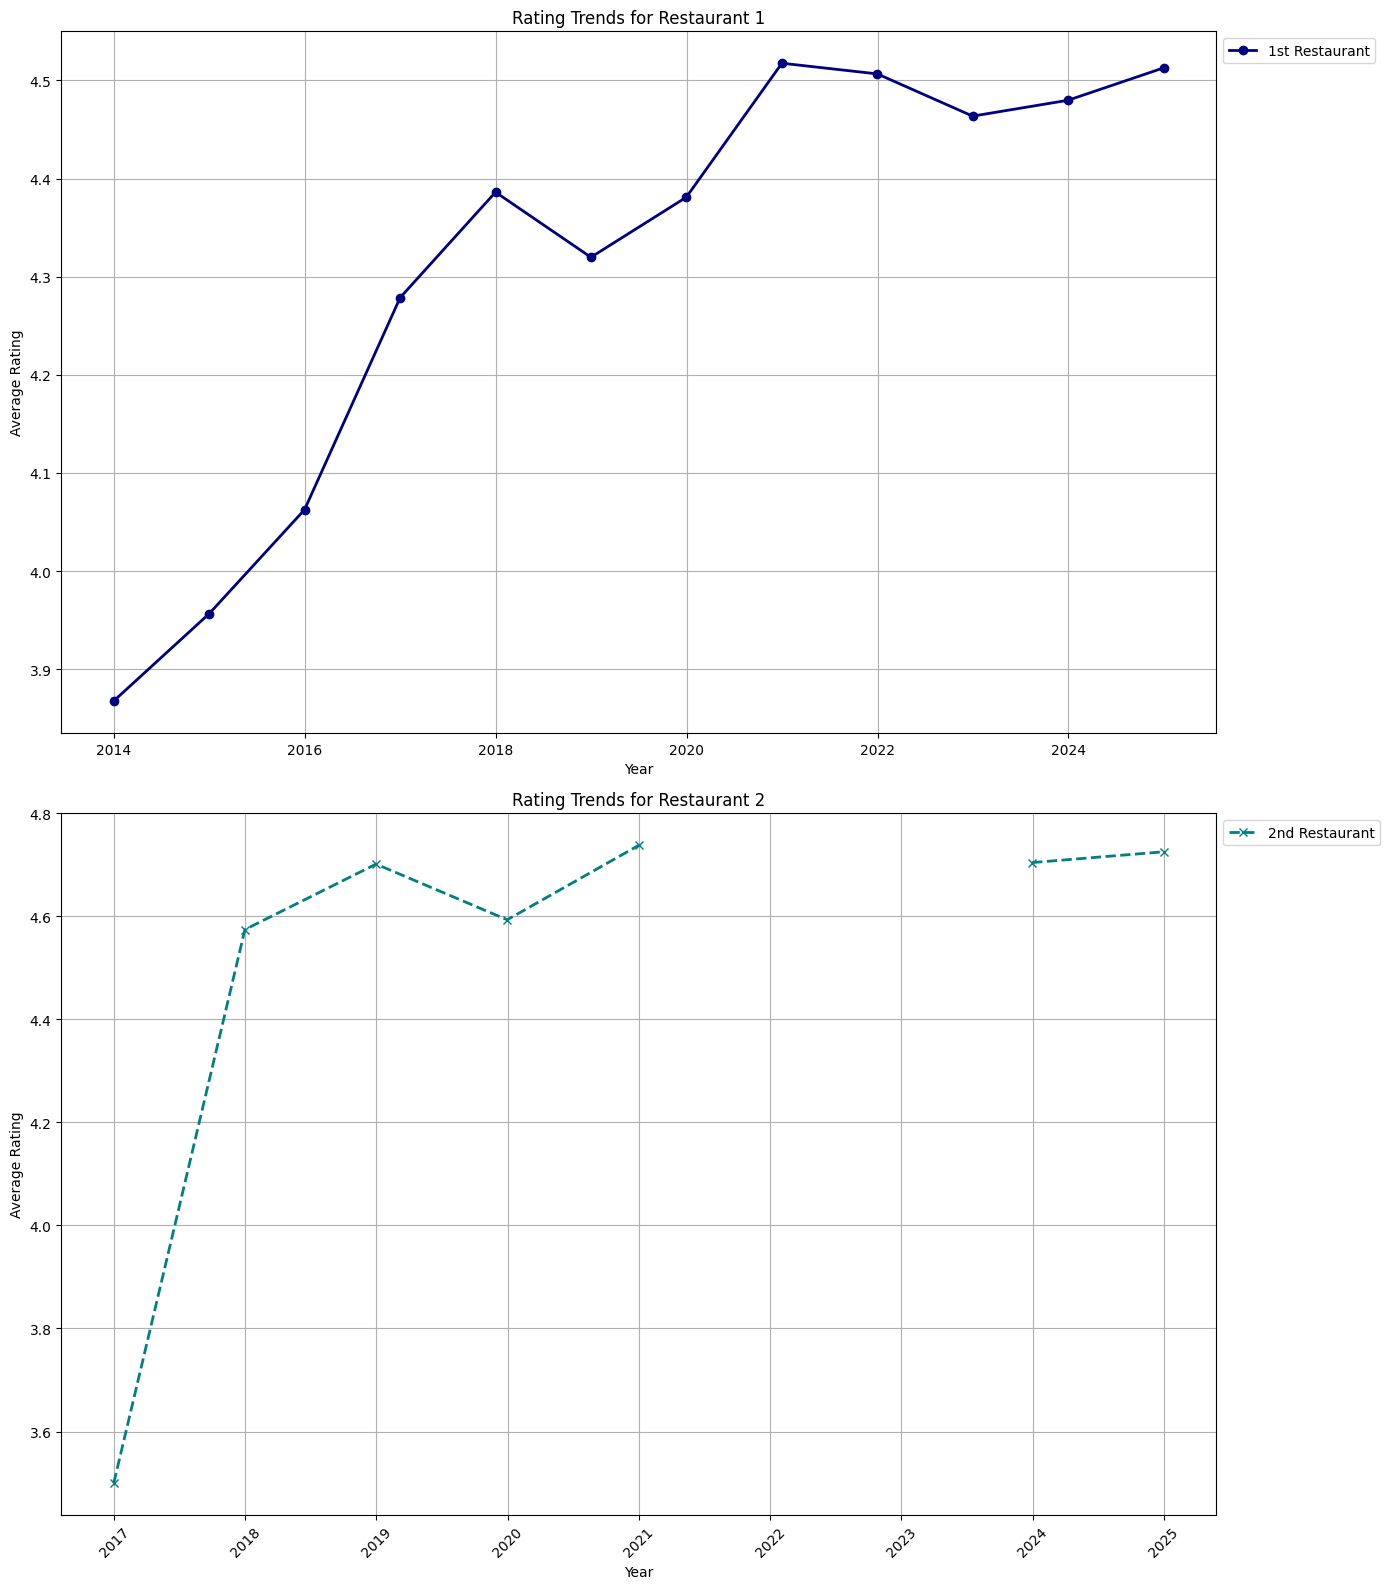

In [5]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def convert_date(date_str):
    if 'days ago' in date_str:
        days_ago = int(date_str.split()[1])
        return datetime.now() - timedelta(days=days_ago)
    elif 'Dined on' in date_str:
        return pd.to_datetime(date_str.replace('Dined on ', ''), format='%B %d, %Y')
    elif 'Dined today' in date_str:
        return datetime.now()
    else:
        return pd.to_datetime(date_str, format="%Y-%m-%d", errors='coerce')

df = pd.read_json('reviews.json')
df2 = pd.read_json('second.json')

df['review_date'] = df["review_date"].apply(convert_date)
df2['review_date'] = df2["review_date"].apply(convert_date)

ratings1 = df["rating"].apply(lambda x: int(x.split()[0]))
ratings2 = df2["rating"].apply(lambda x: int(x.split()[0]))

sample1 = pd.DataFrame({'Date': df['review_date'], 'Rating': ratings1})
sample2 = pd.DataFrame({'Date': df2['review_date'], 'Rating': ratings2})

df1_yearly = sample1.resample('YE', on='Date').mean()
df2_yearly = sample2.resample('YE', on='Date').mean()

ranges = [(2005, 2008), (2009, 2012), (2013, 2016), (2017, 2020), (2021, 2024)]

def filter_range(df, r):
    filtered = []
    for start_year, end_year in r:
        filtered.append(df[(df.index.year >= start_year) & (df.index.year <= end_year)])
    return pd.concat(filtered)

filtered1 = filter_range(df1_yearly, ranges)
filtered2 = filter_range(df2_yearly, ranges)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot for Restaurant 1
ax1.plot(filtered1.index, filtered1['Rating'], label='1st Restaurant', color='navy', marker='o', linestyle='-', linewidth=2)
ax1.set_title('Rating Trends for Restaurant 1')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rating')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.grid(True)

# Plot for Restaurant 2
ax2.plot(filtered2.index, filtered2['Rating'], label='2nd Restaurant', color='teal', marker='x', linestyle='--', linewidth=2)
ax2.set_title('Rating Trends for Restaurant 2')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Rating')
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<hr style="border: 1px solid pink;">

## <font face="Gramond" color="peachpuff"> Part 5: Bonus </font>

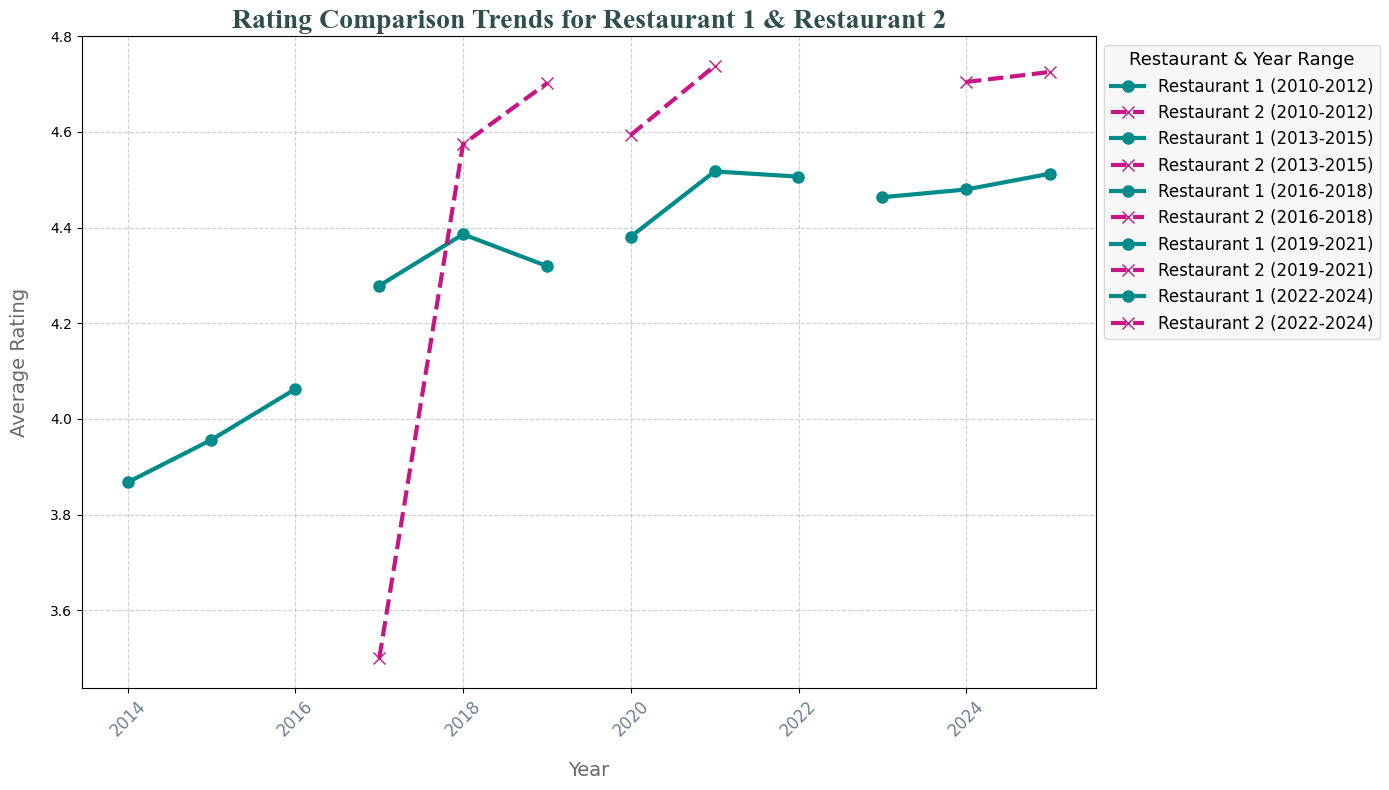

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 8))

for start_year, end_year in ranges:
    df1_range = df1_yearly[(df1_yearly.index.year >= start_year) & (df1_yearly.index.year <= end_year)]
    df2_range = df2_yearly[(df2_yearly.index.year >= start_year) & (df2_yearly.index.year <= end_year)]
    
    ax.plot(df1_range.index, df1_range['Rating'], label=f'Restaurant 1 ({start_year}-{end_year})', color='darkcyan', marker='o', linestyle='-', linewidth=3, markersize=8)
    ax.plot(df2_range.index, df2_range['Rating'], label=f'Restaurant 2 ({start_year}-{end_year})', color='mediumvioletred', marker='x', linestyle='--', linewidth=3, markersize=8)

ax.set_title('Rating Comparison Trends for Restaurant 1 & Restaurant 2', fontsize=20, fontweight='bold', color='darkslategray', fontname='Times New Roman')

ax.set_xlabel('Year', fontsize=14, fontweight='light', color='dimgray', labelpad=15)
ax.set_ylabel('Average Rating', fontsize=14, fontweight='light', color='dimgray', labelpad=15)

plt.xticks(rotation=45, fontsize=12, color='slategray', fontweight='medium')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Restaurant & Year Range', title_fontsize=13, fontsize=12, frameon=True, framealpha=0.7, fancybox=True, facecolor='whitesmoke')

ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()


## <font face="Gramond" color="peachpuff"> Review Summary </font>

In [27]:
import pandas as pd

def overall(df, restaurant_name):
    # Convert ratings to numerical values for calculation
    df['rating_value'] = df['rating'].apply(lambda x: int(x.split()[0]))
    
    avg_rating = df['rating_value'].mean()
    total_reviews = len(df)
    positive_reviews = df[df['rating'] == '5 stars'].shape[0]
    negative_reviews = df[df['rating'] == '1 star'].shape[0]
    
    # Latest review
    latest_review = df.loc[df['review_date'].idxmax()]
    latest_review_content = latest_review['review_content']
    latest_review_date = latest_review['review_date']

    summary = f"""
    Overall Review Summary for {restaurant_name}:
    - Average Rating: {avg_rating:.2f} stars
    - Total Reviews: {total_reviews}
    - Positive Reviews (5 stars): {positive_reviews}
    - Negative Reviews (1 star): {negative_reviews}
    
    Latest Review:
    - Date: {latest_review_date}
    - Review: {latest_review_content}

    """
    return summary

df1 = pd.read_json('reviews.json')
df2 = pd.read_json('second.json')

restaurants_1 = df1['restaurant_name'].unique()
for restaurant in restaurants_1:
    restaurant_df_1 = df1[df1['restaurant_name'] == restaurant]
    print(overall(restaurant_df_1, restaurant))

restaurants_2 = df2['restaurant_name'].unique()
for restaurant in restaurants_2:
    restaurant_df_2 = df2[df2['restaurant_name'] == restaurant]
    print(overall(restaurant_df_2, restaurant))



    Overall Review Summary for Pietro's Italian - Walnut:
    - Average Rating: 4.37 stars
    - Total Reviews: 1878
    - Positive Reviews (5 stars): 1091
    - Negative Reviews (1 star): 27
    
    Latest Review:
    - Date: Dined today
    - Review: Food and service were excellent.  We have been here many times …. Never disappoints

    

    Overall Review Summary for Gary Danko:
    - Average Rating: 4.67 stars
    - Total Reviews: 1638
    - Positive Reviews (5 stars): 1320
    - Negative Reviews (1 star): 26
    
    Latest Review:
    - Date: Dined on September 9, 2023
    - Review: The food was to die for! The bites they keep bringing as the chefs choice made the experience incredible. The service is great.

    


## <font face="Gramond" color="peachpuff"> FINAL DASHBOARD </font>

In [3]:
%%writefile dashboard2.py
import streamlit as st
import json
import base64
import time
import logging
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def load_json_data(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except Exception as e:
        st.error(f"Error loading {file_path}: {e}")
        return []

def display_stars(rating_text):
    try:
        rating = int(rating_text.split()[0]) 
        return "⭐" * rating
    except:
        return "No Rating"

def highlight_text(text, sentiment, category):
    sentiment_color = "peachpuff" if sentiment.lower() in ["positive", "negative"] else "gray"
    if category == "food":
        return f"<span style='color: indianred; font-weight: bold'>{text}</span><br><span style='color: white; font-weight: bold;'>Sentiment: <span style='color: {sentiment_color};'>{sentiment}</span></span>"
    elif category == "service":
        return f"<span style='color: teal; font-weight: bold'>{text}</span><br><span style='color: white; font-weight: bold;'>Sentiment: <span style='color: {sentiment_color};'>{sentiment}</span></span>"
    return text

def add_background(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    st.markdown(
        f"""
        <style>
        .stApp {{
            background-image: url("data:image/jpeg;base64,{encoded_string}");
            background-size: cover;
            background-position: center;
            background-repeat: no-repeat;
        }}
        </style>
        """,
        unsafe_allow_html=True
    )
st.markdown(
    """
    <style>
    /* Sidebar container with gradient background */
    [data-testid="stSidebar"] > div:first-child {
        background: linear-gradient(135deg, #2b2d42, #8d99ae);
        border-radius: 10px;
        padding: 20px;
        color: white;
    }

    /* Sidebar text elements */
    [data-testid="stSidebar"] label {
        font-size: 16px;
        color: white;
        font-weight: bold;
    }

    /* Sidebar radio buttons with hover effect */
    [data-testid="stSidebar"] .st-radio div {
        background: rgba(255, 255, 255, 0.1);
        border-radius: 5px;
        padding: 8px;
        margin-bottom: 5px;
        color: white;
        transition: background 0.3s;
    }

    [data-testid="stSidebar"] .st-radio div:hover {
        background: rgba(255, 255, 255, 0.3);
    }

    /* Styled selectbox */
    [data-testid="stSidebar"] .stSelectbox {
        background: rgba(255, 255, 255, 0.1);
        border-radius: 5px;
        color: white;
        padding: 5px;
    }

    /* Input fields */
    [data-testid="stSidebar"] .stTextInput {
        background: rgba(255, 255, 255, 0.1);
        border-radius: 5px;
        color: white;
        padding: 8px;
    }

    /* Header styling */
    [data-testid="stSidebar"] h3 {
        font-size: 20px;
        color: white;
        text-align: left;
        margin-bottom: 10px;
    }
    </style>
    """,
    unsafe_allow_html=True
)



background_image = "ele.jpg"

def overall(df, restaurant_name):
    df['rating_value'] = df['rating'].apply(lambda x: int(x.split()[0]))
    
    avg_rating = df['rating_value'].mean()
    total_reviews = len(df)
    positive_reviews = df[df['rating'] == '5 stars'].shape[0]
    negative_reviews = df[df['rating'] == '1 star'].shape[0]
    
    # Latest review
    latest_review = df.loc[df['review_date'].idxmax()]
    latest_review_content = latest_review['review_content']
    latest_review_date = latest_review['review_date']

    summary = f"""
    Overall Review Summary for {restaurant_name}:
    - Average Rating: {avg_rating:.2f} stars
    - Total Reviews: {total_reviews}
    - Positive Reviews (5 stars): {positive_reviews}
    - Negative Reviews (1 star): {negative_reviews}
    
    Latest Review:
    - Date: {latest_review_date}
    - Review: {latest_review_content}

    """
    return summary

def convert_date(date_str):
    if 'days ago' in date_str:
        days_ago = int(date_str.split()[1])
        return datetime.now() - timedelta(days=days_ago)
    elif 'Dined on' in date_str:
        return pd.to_datetime(date_str.replace('Dined on ', ''), format='%B %d, %Y')
    elif 'Dined today' in date_str:
        return datetime.now()
    else:
        return pd.to_datetime(date_str, format="%Y-%m-%d", errors='coerce')
        
def scrape_opentable_reviews(url):
    try:
        logging.basicConfig(level=logging.DEBUG)
        try:
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
        except Exception as e:
            logging.error(f"Error initializing ChromeDriver: {e}")
            st.error(f"Error initializing ChromeDriver: {e}")
            return []

        driver.get(url)
        time.sleep(3) 

        data = []
      
        try:
            restaurant_name = driver.find_element(By.CLASS_NAME, 'E-vwXONV9nc-').text
            logging.info(f"Restaurant Name: {restaurant_name}")
        except Exception as e:
            logging.error(f"Error extracting restaurant name: {e}")
            st.error("Error extracting restaurant name.")
            driver.quit()
            return []

        while True:
            try:
                names = driver.find_elements(By.CLASS_NAME, '_0Uufw15R3a4-')
                customer_names = [name.find_element(By.CLASS_NAME, '_1p30XHjz2rI-').text for name in names if name.text]

                items = driver.find_elements(By.CLASS_NAME, 'MpiILQAMSSg-')
                for i in range(len(items)):
                    try:
                        content = items[i].find_element(By.CLASS_NAME, '_6rFG6U7PA6M-')
                        date = items[i].find_element(By.CLASS_NAME, 'iLkEeQbexGs-')
                        rating_element = items[i].find_element(By.CLASS_NAME, 'yEKDnyk-7-g-')
                        rating = rating_element.get_attribute("aria-label")
                        
                        customer_name = customer_names[i] if i < len(customer_names) else None
                        
                        data.append({
                            "restaurant_name": restaurant_name,
                            "customer_name": customer_name,
                            "review_content": content.text,
                            "rating": rating,
                            "review_date": date.text
                        })
                    except Exception as e:
                        logging.error(f"Error processing review item: {e}")

                logging.info("Page Loaded - Collecting data...")

                # Check for the Next button and navigate if available
                footer = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, '_1BEc9Aeng-Q-'))
                )
                buttons = footer.find_elements(By.CLASS_NAME, 'TkpxbcBbu80-')
                
                if len(buttons) > 1:
                    next_button = buttons[1]
                else:
                    next_button = buttons[0]

                if "disabled" in next_button.get_attribute("class") or not next_button.is_displayed():
                    logging.info("No more pages to load.")
                    break 

                next_button.click()
                logging.info("Navigating to the next page...")
                time.sleep(3)
            
            except Exception as e:
                logging.error(f"Error navigating to the next page: {e}")
                break

        driver.quit() 
        return data
    
    except Exception as e:
        logging.error(f"Error while scraping reviews: {e}")
        st.error(f"Error while scraping reviews: {e}")
        return []


processed_reviews = load_json_data("final_reviews.json")
original_reviews = load_json_data("reviews.json")
add_background(background_image)

st.title("Minah's Dashboard")

option = st.sidebar.radio("Choose an Option", ["Reviews", "Charts", "Review Summary"])

if option == "Reviews":
    competitor_url = st.text_input("Enter OpenTable link for competitor restaurant:")
    if st.button("Scrape and Compare Ratings"):
        st.info("Starting data scraping...")
        competitor_reviews = scrape_opentable_reviews(competitor_url)
        if competitor_reviews:
            st.success(f"Scraped {len(competitor_reviews)} reviews!")
            for review in competitor_reviews:
                with st.expander(f"Review by {review['customer_name']}"):
                    st.write(f"*Review Date:* {review['review_date']}")
                    st.write(f"*Rating:* {display_stars(review['rating'])}")
                    st.markdown(f"*Review Content:* {review['review_content']}")

    st.sidebar.header("Filter Reviews")
    filter_rating = st.sidebar.selectbox("Filter by Rating:", ["All", "5 stars", "4 stars", "3 stars", "2 stars", "1 star"])
    search_customer = st.sidebar.text_input("Search by Customer Name:")

    for original, processed in zip(original_reviews, processed_reviews):
        customer_name = original.get("customer_name", "Unknown Customer")
        review_content = original.get("review_content", "No review content available")
        rating = original.get("rating", "No Rating")
        stars = display_stars(rating)
        review_date = original.get("review_date", "No Date")
        food_quality = processed.get("food_quality", {"comment": "No Food Review", "sentiment": "Neutral"})
        staff_service = processed.get("staff_service", {"comment": "No Service Review", "sentiment": "Neutral"})

        if filter_rating != "All" and filter_rating != rating:
            continue
        if search_customer and search_customer.lower() not in customer_name.lower():
            continue

        with st.expander(f"Review by {customer_name}"):
            st.write(f"*Review Date:* {review_date}")
            st.write(f"*Rating:* {stars}")
            st.markdown(f"*Review Content:* {review_content}")
            st.markdown(f"<br><b>Food Quality:</b> {highlight_text(food_quality['comment'], food_quality['sentiment'], 'food')}", unsafe_allow_html=True)
            st.markdown(f"<br><b>Staff Service:</b> {highlight_text(staff_service['comment'], staff_service['sentiment'], 'service')}", unsafe_allow_html=True)



elif option == "Charts":
    df1 = pd.read_json('reviews.json')  
    df2 = pd.read_json('second.json') 

    df1['review_date'] = df1["review_date"].apply(convert_date)
    df2['review_date'] = df2["review_date"].apply(convert_date)

    ratings1 = df1["rating"].apply(lambda x: int(x.split()[0]))
    ratings2 = df2["rating"].apply(lambda x: int(x.split()[0]))

    sample1 = pd.DataFrame({'Date': df1['review_date'], 'Rating': ratings1})
    sample2 = pd.DataFrame({'Date': df2['review_date'], 'Rating': ratings2})

    yearly1 = sample1.resample('YE', on='Date').mean()
    yearly2 = sample2.resample('YE', on='Date').mean()

    ranges = [(2005, 2008), (2009, 2012), (2013, 2016), (2017, 2020), (2021, 2024)]

    def filter_range(df, r):
        filtered = []
        for start_year, end_year in r:
            filtered.append(df[(df.index.year >= start_year) & (df.index.year <= end_year)])
        return pd.concat(filtered)

    filtered1 = filter_range(yearly1, ranges)
    filtered2 = filter_range(yearly2, ranges)

    st.subheader('Rating Trends for Each Restaurant')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

    # Plot for Restaurant 1
    ax1.plot(filtered1.index, filtered1['Rating'], label='Restaurant 1', color='navy', marker='o', linestyle='-', linewidth=2)
    ax1.set_title('Rating Trends for Restaurant 1')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Rating')
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax1.grid(True)

    # Plot for Restaurant 2
    ax2.plot(filtered2.index, filtered2['Rating'], label='Restaurant 2', color='teal', marker='x', linestyle='--', linewidth=2)
    ax2.set_title('Rating Trends for Restaurant 2')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Average Rating')
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    st.pyplot(fig)

    st.subheader('Comparison of Rating Trends Between Restaurants')

    fig, ax = plt.subplots(figsize=(14, 8))

    for start_year, end_year in ranges:
        range1 = yearly1[(yearly1.index.year >= start_year) & (yearly1.index.year <= end_year)]
        range2 = yearly2[(yearly2.index.year >= start_year) & (yearly2.index.year <= end_year)]

        ax.plot(range1.index, range1['Rating'], label=f'Restaurant 1 ({start_year}-{end_year})', color='teal', marker='o', linestyle='-', linewidth=3, markersize=8)
        ax.plot(range2.index, range2['Rating'], label=f'Restaurant 2 ({start_year}-{end_year})', color='mediumvioletred', marker='x', linestyle='--', linewidth=3, markersize=8)

    ax.set_title('Rating Comparison Trends for Restaurant 1 & Restaurant 2', fontsize=20, fontweight='bold', color='darkslategray', fontname='Times New Roman')
    ax.set_xlabel('Year', fontsize=14, fontweight='light', color='dimgray', labelpad=15)
    ax.set_ylabel('Average Rating', fontsize=14, fontweight='light', color='dimgray', labelpad=15)

    plt.xticks(rotation=45, fontsize=12, color='slategray', fontweight='medium')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Restaurant & Year Range', title_fontsize=13, fontsize=12, frameon=True, framealpha=0.7, fancybox=True, facecolor='whitesmoke')
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    st.pyplot(fig)


elif option == "Review Summary":
    
    df1 = pd.read_json('reviews.json') 
    df2 = pd.read_json('second.json')  
    restaurants_1 = df1['restaurant_name'].unique()
    
    for restaurant in restaurants_1:
        restaurant_df_1 = df1[df1['restaurant_name'] == restaurant]
        summary_1 = overall(restaurant_df_1, restaurant)
        st.markdown(f"### {restaurant}")
        st.markdown(summary_1)
    
    restaurants_2 = df2['restaurant_name'].unique()
    
    for restaurant in restaurants_2:
        restaurant_df_2 = df2[df2['restaurant_name'] == restaurant]
        summary_2 = overall(restaurant_df_2, restaurant)
        st.markdown(f"### {restaurant}")
        st.markdown(summary_2)

st.markdown("---")
st.markdown("### - by Minahil Rizwan")


Overwriting dashboard2.py


<hr style="border: 1px solid pink;">